# Exploratory Data Analysis - TripAdvisor data

In [6]:
import pandas as pd

from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

## Visualisation of a restaurant's reviews

In [18]:
restaurants = pd.read_json('../scraper/scraped_data/restaurants.json', lines=True)
restaurants = list(restaurants['restaurant_id'])

In [41]:
restaurant_id = "0"
while (restaurant_id not in restaurants):
    try:
        restaurant_id = int(input("Enter restaurant id from 1 to 143 : "))
    except:
        print("Please enter int")
directory = './restaurant_word_frequencies/'

Enter restaurant id from 1 to 143 : hjkly
Please enter int
Enter restaurant id from 1 to 143 : 15999
Enter restaurant id from 1 to 143 : 143


### TF-IDF matrix

In [8]:
df_tfidf = pd.read_csv(directory + "restaurant_" + str(restaurant_id) + "_word_freq.csv", index_col=['Unnamed: 0'])

In [9]:
df_tfidf.head()

,00,10,100,11,12,12th,13,14,14k,15,...,yellow,yes,yesterday,yogurt,yorkshire,young,yummy,yup,zinging,zoom
35048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
df_tfidf_mean.head()

,tfidf mean
food,0.066797
restaurant,0.052530
service,0.044746
staff,0.043994
good,0.043901


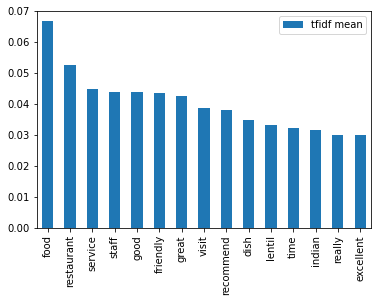

In [11]:
df_tfidf_mean[:15].plot(kind='bar')
plt.show()

### Wordcloud visualisation

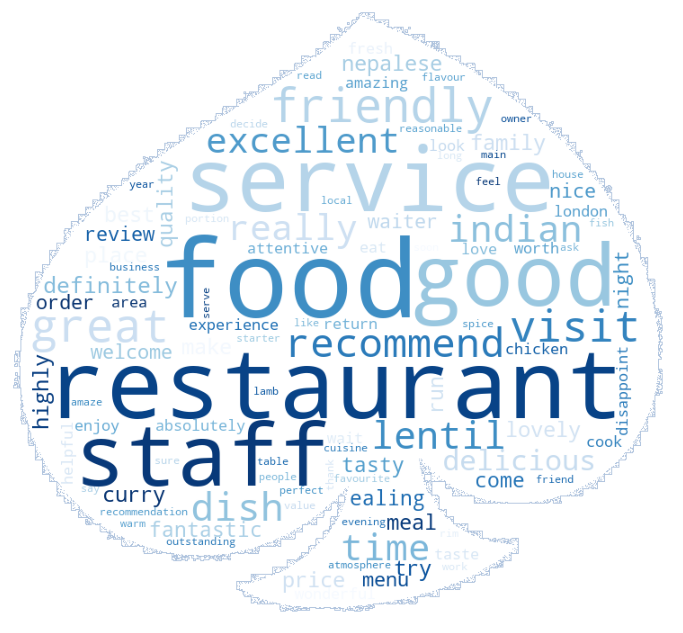

In [12]:
img = plt.imread('./restaurant_wordclouds/restaurant_' + str(restaurant_id) + '_word_cloud.png')
plt.figure(figsize=(12,16))
plt.imshow(img)
plt.axis("off")
plt.show()

Other wordclouds and TF-IDF can be found in the dedicated folder